## Spatial smoothing

Try to improve our predictions using spatial smoothing...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import smooth

## Load data

In [2]:
df = pd.read_csv('data/best.csv')

Wrangle data

In [3]:
RE = smooth.RE
preds = \
    df[[RE, 'chunk_id', 'Pos', 'Ref', 'Alt', 'class', 'Confidence', 'Value', 'PredValue']]. \
    set_index([RE, 'chunk_id', 'Pos'])
preds.head(6)

Ref Alt  class  Confidence  Value  \
regulatory_element chunk_id Pos                                           
release_F9         0        138612669   T   A      0        0.07  -0.17   
                            138612669   T   C     -1        0.24  -0.26   
                            138612669   T   G      0        0.05   0.34   
                            138612670   A   C      0        0.00   0.00   
                            138612670   A   G      1        0.20   0.22   
                            138612670   A   T      0        0.03   0.12   

                                       PredValue  
regulatory_element chunk_id Pos                   
release_F9         0        138612669  -0.267628  
                            138612669  -0.450332  
                            138612669  -0.126616  
                            138612670  -0.199390  
                            138612670  -0.171700  
                            138612670  -0.117500

## Residuals

In [4]:
preds['Residuals'] = preds['PredValue'] - preds['Value']

Text(0,0.5,'residual')

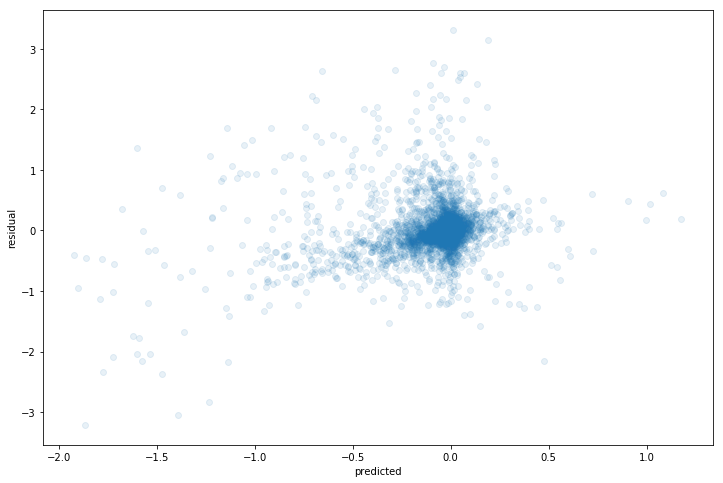

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(preds['PredValue'], preds['Residuals'], alpha=.1)
ax.set_xlabel('predicted')
ax.set_ylabel('residual')

## Smooth

Aggregate the values at each position and smooth them

In [6]:
smoothed = smooth.smooth_df(preds, aggfn=smooth.medianabs, lengthscale=2)
smoothed.sample(9)

PredSmoothedAgg  SmoothedAgg  \
regulatory_element   chunk_id Pos                                       
release_ZFAND3       7        37775682          0.028819     0.080488   
release_IRF4         7        396580            0.026395     0.100340   
release_SORT1        5        109817550         0.553970     0.958818   
release_PKLR         2        155271360         0.083888     0.718383   
                     7        155271636         0.022492     0.161043   
release_ZFAND3       3        37775465          0.009960     0.106689   
release_HNF4A        1        42984346          0.033958     0.025853   
release_IRF4         7        396576            0.020599     0.070104   
release_MYCrs6983267 8        128413658         0.015961     0.031495   

                                         PredValueAgg  ValueAgg  
regulatory_element   chunk_id Pos                                
release_ZFAND3       7        37775682       0.022990      0.04  
release_IRF4         7        396580         0.007602      0.26  
release_SORT1        5        109817550      0.715408      1.56  
release_PKLR         2        155271360      0.043720      0.85  
                     7        155271636      0.044053      0.07  
release_ZFAND3       3        37775465       0.002891      0.15  
release_HNF4A        1        42984346       0.097917      0.03  
release_IRF4         7        396576         0.014648      0.04  
release_MYCrs6983267 8        128413658      0.005437      0.02

Plot smoothing to check it worked

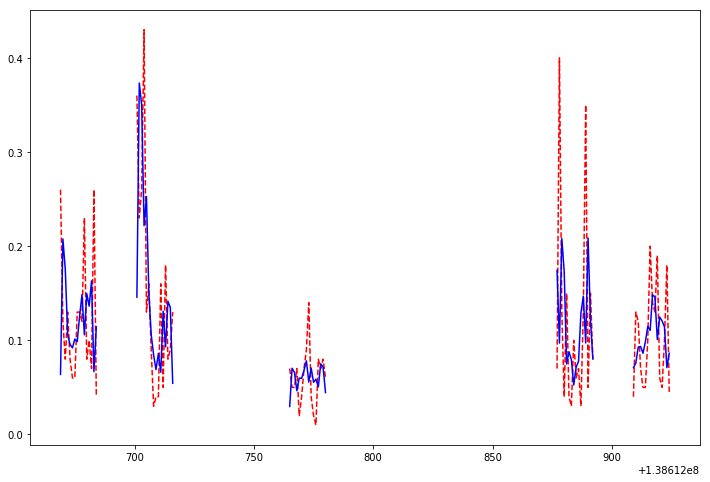

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
F9 = smoothed.loc['release_F9'].reset_index('Pos')
for chunkid, chunk in F9.groupby('chunk_id'):
    ax.plot(
        chunk['Pos'],
        chunk['ValueAgg'],
        linestyle='dashed',
        color='r')
    ax.plot(
        chunk['Pos'],
        chunk['SmoothedAgg'],
        # linestyle='dashed',
        color='b')

Scatter plot the relationship between the smoothed maximum absolute values and the maximum absolute values

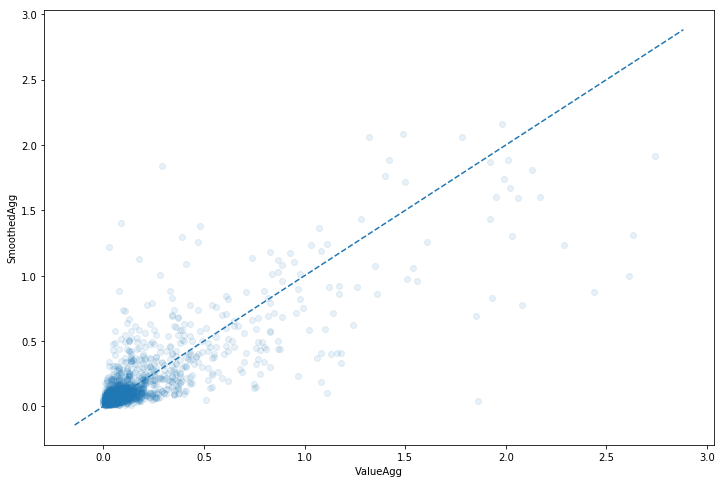

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(smoothed['ValueAgg'], smoothed['SmoothedAgg'], alpha=.1)
ax.set_xlabel('ValueAgg')
ax.set_ylabel('SmoothedAgg')
# ax.set_yscale('log')
# ax.set_xscale('log')
x_vals = np.array(ax.get_xlim())
ax.plot(x_vals, x_vals, '--')

In [9]:
print(np.corrcoef(smoothed['ValueAgg'], smoothed['SmoothedAgg']))

[[1.         0.79624912]
 [0.79624912 1.        ]]


## Smoothed vs. values

Merge the smoothed aggregate values with the actual values

In [10]:
allpreds = preds.merge(smoothed, left_index=True, right_index=True)
allpreds.sample(9)

,,,Ref,Alt,class,Confidence,Value,PredValue,Residuals,PredSmoothedAgg,SmoothedAgg,PredValueAgg,ValueAgg
regulatory_element,chunk_id,Pos,,,,,,,,,,,
release_HBB,1,5248351,C,G,0,0.00,-0.02,-0.069085,-0.049085,0.123766,0.161680,0.085525,0.21
release_HNF4A,1,42984342,C,T,0,0.04,0.03,0.033016,0.003016,0.025293,0.048295,0.025960,0.04
release_IRF6,3,209989493,C,G,0,0.03,-0.57,-0.080617,0.489383,0.028610,0.638723,0.031921,0.12
release_IRF4,7,396582,C,A,0,0.08,0.14,-0.044021,-0.184021,0.015911,0.105002,0.009376,0.16
release_PKLR,0,155271236,G,T,1,0.14,0.51,-0.056722,-0.566722,0.702995,0.257265,0.927641,0.38
release_ZFAND3,1,37775377,G,C,0,0.00,-0.03,-0.038705,-0.008705,0.019498,0.035436,0.031828,0.02
release_MSMB,2,51549164,T,G,0,0.01,0.04,-0.011499,-0.051499,0.017111,0.031089,0.028524,0.04
release_HNF4A,2,42984374,G,C,0,0.00,-0.01,-0.019888,-0.009888,0.016901,0.015694,0.008368,0.04
release_HBB,0,5248276,A,G,0,0.01,-0.01,-0.107456,-0.097456,0.064162,0.079780,0.125361,0.06


Scatter plot the smoothed maximum absolute values against the actual values

(4650, 11)

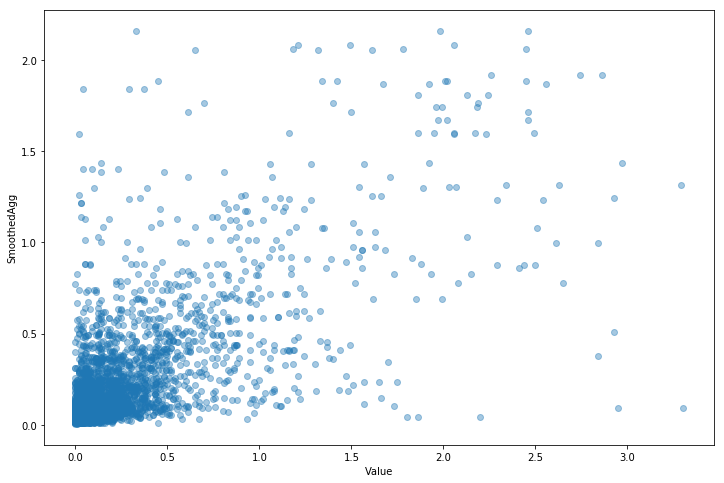

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(np.abs(allpreds['Value']), allpreds['SmoothedAgg'], alpha=.4)
ax.set_xlabel('Value')
ax.set_ylabel('SmoothedAgg')
# ax.set_yscale('log')
# ax.set_xscale('log')
# x_vals = np.array(ax.get_xlim())
# ax.plot(x_vals, x_vals, '--')
allpreds.shape

In [12]:
print(np.corrcoef(np.abs(allpreds['Value']), allpreds['SmoothedAgg']))

[[1.         0.69785536]
 [0.69785536 1.        ]]


## Hyperparameters

Search for good lengthscale and aggregation function.

In [13]:
hypersearch = []
for aggfn in [
    # smooth.maxmag,
    smooth.maxabs,
    smooth.meanabs,
    smooth.medianabs,
]:
    for lengthscale in [.5, 1, 1.5, 2, 2.5, 3, 5, 8]:
        smoothed = smooth.smooth_df(preds, aggfn=aggfn, lengthscale=lengthscale)
        allpreds = preds.merge(smoothed, left_index=True, right_index=True)
        corr = np.corrcoef(np.abs(allpreds['Value']), allpreds['SmoothedAgg'])[1, 0]
        hypersearch.append((corr, aggfn.__name__, lengthscale))
        print("""Aggregation: {}; lengthscale: {}; correlation: {}""".format(
            aggfn.__name__, lengthscale, corr))

Aggregation: maxabs; lengthscale: 0.5; correlation: 0.6412224891222217
Aggregation: maxabs; lengthscale: 1; correlation: 0.6484445102162838
Aggregation: maxabs; lengthscale: 1.5; correlation: 0.6682508230302545
Aggregation: maxabs; lengthscale: 2; correlation: 0.6768577209998186
Aggregation: maxabs; lengthscale: 2.5; correlation: 0.6777507205547341
Aggregation: maxabs; lengthscale: 3; correlation: 0.674601019794379
Aggregation: maxabs; lengthscale: 5; correlation: 0.6471753686102573
Aggregation: maxabs; lengthscale: 8; correlation: 0.6120030882161617
Aggregation: meanabs; lengthscale: 0.5; correlation: 0.6713327532770228
Aggregation: meanabs; lengthscale: 1; correlation: 0.6770423995129813
Aggregation: meanabs; lengthscale: 1.5; correlation: 0.6916592259478765
Aggregation: meanabs; lengthscale: 2; correlation: 0.6967982315165631
Aggregation: meanabs; lengthscale: 2.5; correlation: 0.696059329748278
Aggregation: meanabs; lengthscale: 3; correlation: 0.6921042164592953
Aggregation: meana

In [14]:
hypersearch.sort()
hypersearch[-5:]

[(0.6936521336004322, 'medianabs', 3),
 (0.696059329748278, 'meanabs', 2.5),
 (0.6967982315165631, 'meanabs', 2),
 (0.69735187683218, 'medianabs', 2.5),
 (0.6978553594685818, 'medianabs', 2)]

## Test scoring

Test if we can use smoothed predictions to improve the scoring.

In [15]:
print(df.columns)
df[['class', 'Confidence']]
neg = df['class'] == -1
zero = df['class'] == 0
pos = df['class'] == 1
print(df.loc[neg, 'Confidence'].min())
print(df.loc[neg, 'Value'].max())
print(df.loc[zero, 'Confidence'].min())
print(df.loc[zero, 'Confidence'].max())
print(df.loc[pos, 'Value'].min())
print(df.loc[pos, 'Confidence'].min())

Index(['Unnamed: 0', '#Chrom', 'Pos', 'Ref', 'Alt', 'Value', 'Confidence',
       'class', 'regulatory_element', 'phastCon', 'phyloP', 'GerpN', 'GerpRS',
       'is_break', 'chunk_length', 'is_start', 'chunk_id', 'is_train',
       'PredConfidence', 'PredValue'],
      dtype='object')
0.1
-0.05
0.0
0.09
0.06
0.1


In [21]:
smoothed = smooth.smooth_df(preds, aggfn=smooth.medianabs, lengthscale=2)
allpreds = preds.merge(smoothed, left_index=True, right_index=True)
print(allpreds.columns)

Index(['Ref', 'Alt', 'class', 'Confidence', 'Value', 'PredValue', 'Residuals',
       'PredSmoothedAgg', 'SmoothedAgg', 'PredValueAgg', 'ValueAgg'],
      dtype='object')


In [22]:
from utils import pr
_, _, _, auprc_pred = pr(allpreds, 'PredValue')
_, _, _, auprc_smooth = pr(allpreds, 'PredSmoothedAgg')

In [23]:
print(auprc_pred, auprc_smooth)

0.4667645574770587 0.44491454573322975
